In [1]:
import gensim
import gensim.downloader
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
import numpy as np
import tempfile
import imageio
import shutil
import os
from statistics import mean
import pandas as pd 
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer 
from gensim.test.utils import datapath
from gensim.models.fasttext import load_facebook_vectors

from IPython.display import Image
from IPython.display import display
pd.options.display.max_columns = None

import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

In [3]:
TOP_N = 30
KEYS = { \
    "offensive": set(), 
    "abusive": set(), 
    "cyberbullying": set(), 
    "vulgar": set(), 
    "racist": set(), 
    "homophobic": set(), 
    "profane": set(), 
    "slur": set(), 
    "harrasment": set(), 
    "obscene": set(), 
    "threat": set(), 
    "discredit": set(), 
    "hateful": set(), 
    "insult": set(), 
    "hostile": set(),
    "sexism": set(),
    "spam": set(),
    "benevolent": set(),
    "hate_speech": set(),
    "toxic": set(),        
}
FIXED_KEYS = list(KEYS.keys())

In [4]:
lemmatizer = WordNetLemmatizer() 
ps = PorterStemmer() 


for key in KEYS.keys():
    lemma = lemmatizer.lemmatize(key)
    stem = ps.stem(key)
    KEYS[key].add(lemma)
    KEYS[key].add(stem)
    KEYS[key].add(key)
KEYS

{'offensive': {'offens', 'offensive'},
 'abusive': {'abus', 'abusive'},
 'cyberbullying': {'cyberbulli', 'cyberbullying'},
 'vulgar': {'vulgar'},
 'racist': {'racist'},
 'homophobic': {'homophob', 'homophobic'},
 'profane': {'profan', 'profane'},
 'slur': {'slur'},
 'harrasment': {'harras', 'harrasment'},
 'obscene': {'obscen', 'obscene'},
 'threat': {'threat'},
 'discredit': {'discredit'},
 'hateful': {'hate', 'hateful'},
 'insult': {'insult'},
 'hostile': {'hostil', 'hostile'},
 'sexism': {'sexism'},
 'spam': {'spam'},
 'benevolent': {'benevol', 'benevolent'},
 'hate_speech': {'hate_speech'},
 'toxic': {'toxic'}}

In [6]:
def same_word(similar_word, ommit_words):
    similar_word = similar_word.replace("_", " ").replace("-", " ").lower()
    
    if similar_word in ommit_words:
        print(f"{ommit_words} -- {similar_word}")
        return True
    
    for ommit_word in ommit_words:
        if ommit_word in similar_word:
            print(f"{ommit_words} -- {similar_word}")
            return True
        
    return False

In [7]:
def getSimilarWords(model_gn):
    embedding_clusters = []
    word_clusters = []
    for key in FIXED_KEYS:
        ommit_words = KEYS[key]
        embeddings = []
        words = []
        for similar_word, _ in model_gn.most_similar(key, topn=TOP_N * 3):
            if not same_word(similar_word, ommit_words):
                words.append(similar_word)
                embeddings.append(model_gn[similar_word])
                
        if len(words) < TOP_N or len(embeddings) < TOP_N:
            print("ERROR")
            
        words = words[:TOP_N]
        embeddings = embeddings[:TOP_N]
        
        embedding_clusters.append(embeddings)
        word_clusters.append(words)
        
    return (word_clusters, embedding_clusters)

In [8]:
def displayDF(word_clusters):
    df = pd.DataFrame(dict(zip(FIXED_KEYS, word_clusters)))  
    display(df)

In [9]:
def plot_similar_words(title, labels, embedding_clusters, word_clusters, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=0.7, label=label)
        for i, word in enumerate(words):              
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
        plt.annotate(label.upper(), alpha=1.0, xy=(mean(x), mean(y)), xytext=(0, 0),
            textcoords='offset points', ha='center', va='center', size=15)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(False)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

In [10]:
def plotTSNE(title, word_clusters, embedding_clusters, filename = None):
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
    model_en_2d = model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))
    embeddings_en_2d = np.array(model_en_2d).reshape(n, m, 2)
    plot_similar_words(title, FIXED_KEYS, embeddings_en_2d, word_clusters, filename)

In [11]:
def plotMDS(title, word_clusters, embedding_clusters, filename = None):
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    model_en_2d = MDS(n_components=2, max_iter=3500, random_state=32)
    model_en_2d = model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))
    embeddings_en_2d = np.array(model_en_2d).reshape(n, m, 2)
    plot_similar_words(title, FIXED_KEYS, embeddings_en_2d, word_clusters, filename)

In [12]:
def plotPCA(title, word_clusters, embedding_clusters, filename = None):
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    model_en_2d = PCA(n_components=2, random_state = 32)
    model_en_2d = model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))
    embeddings_en_2d = np.array(model_en_2d).reshape(n, m, 2)
    plot_similar_words(title, FIXED_KEYS, embeddings_en_2d, word_clusters, filename)

In [13]:
model_gn = gensim.downloader.load('word2vec-google-news-300')

In [15]:
word_clusters_a, embedding_clusters = getSimilarWords(model_gn)

{'offensive', 'offens'} -- offensive
{'offensive', 'offens'} -- offensively
{'offensive', 'offens'} -- offense
{'offensive', 'offens'} -- offensively
{'offensive', 'offens'} -- offensive line
{'offensive', 'offens'} -- offensive firepower
{'abus', 'abusive'} -- abusive
{'abus', 'abusive'} -- verbally abusive
{'abus', 'abusive'} -- abuse
{'abus', 'abusive'} -- verbal abuse
{'abus', 'abusive'} -- abused
{'abus', 'abusive'} -- physically abused
{'abus', 'abusive'} -- abuser
{'abus', 'abusive'} -- abusive neglectful
{'abus', 'abusive'} -- verbal abuse
{'abus', 'abusive'} -- profane abusive
{'abus', 'abusive'} -- sexually abusive
{'abus', 'abusive'} -- verbally abused
{'abus', 'abusive'} -- abusing
{'abus', 'abusive'} -- sexually abused
{'abus', 'abusive'} -- abusive profane
{'abus', 'abusive'} -- verbally abusing
{'abus', 'abusive'} -- nonabusive
{'abus', 'abusive'} -- physically abusing
{'cyberbulli', 'cyberbullying'} -- cyberbullying
{'cyberbulli', 'cyberbullying'} -- cyberbullies
{'cybe

In [16]:
displayDF(word_clusters_a)

,offensive,abusive,cyberbullying,vulgar,racist,homophobic,profane,slur,harrasment,obscene,threat,discredit,hateful,insult,hostile,sexism,spam,benevolent,hate_speech,toxic
0,defensive,graphically_depicts_physically,cyber_bullying,profane,racism,racist,vulgar,derogatory,harassment,vulgar,danger,malign,bigoted,affront,unfriendly,sexist,phishing,beneficent,No_vulgarity_racial,poisonous
1,coach_Bob_Palcic,Luke_McNorton,sexting,obscene,anti_Semitic,gay_bashing,obscenities,racist_remark,Harassment,indecent,imminent_danger,besmirch,racist,disrespect,antagonistic,misogyny,malware,magnanimous,Foul_language,toxins
2,guard_RJ_Mattes,Dorian_Wesson,bullying,crass,bigoted,antigay,vulgar_language,epithet,harassments,pornographic,menace,embarrass,vile,disrespectful,nipple_pinching,racism,spim,beneficence,Hate_Speech,persistent_bio_accumulative
3,coach_Jimmy_Heggins,inappropriate,Cyber_bullying,rude,homophobic,transphobic,foul_language,derogatory_remark,harassement,lewd,challenge,delegitimize,hurtful,disgrace,warlike,ageism,spyware,altruistic,Biden_decries_unbecoming,noxious
4,promoted_Pete_Metzelaars,adequate_Tamberg,cyberstalking,demeaning,hateful,gay,expletives,word_nigger,ASPEN_Colo._Actor,sexually_explicit,dangers,demonize,mean_spirited,denigrate,unwelcoming,gender_bias,Spim,saintly,libel_defamation,harmful
5,Dave_Borbely,rude,Bullying,politically_incorrect,anti_semitic,homosexual,curse_words,remark,Verbal_abuse,filthy_diatribe,hazard,smear,anti_semetic,demean,mistaken_celebratory_gunfire,homophobia,Pushdo_botnet,malevolent,profanity_obscenity,radioactive
6,coach_George_Yarno,Mo'Nique_searing,cyberbully,sexist,rascist,bigoted,hateful,racial_epithet,violance,inappropriate,nightmare_scenario,marginalize,bigotry,humiliate,confrontational,male_chauvinism,sender_authentication,generous,ad_hominen_attacks,hazardous
7,coach_Dave_Magazu,Advocate_Safehouse_Project,Cyber_Bullying,raunchy,racialist,anti_Semitic,foul_mouthed,derogatory_language,sexual_harassments,disgusting,possibility,vilify,vitriolic,dishonor,inhospitable,bigotry,blocklists,munificent,obscene_sexually_explicit,chemical_methyl_isocyanate
8,coach_Greg_Studrawa,behaves_unreasonably_yells,schoolyard_bullying,culturally_insensitive_inappropriate,racially_motivated,hateful,politically_incorrect,racist_connotations,verbal_abuse,outrageous,peril,denigrate,racist_sexist_homophobic,disrespecting,belligerent,sexist_attitudes,Pushdo,tyrannical,containing_advertising_astroturfing,tributyl_tin
9,coach_Dan_Roushar,delete_inappropriate,cyber_bulling,obnoxious,sexist,anti_semitic,containing_advertising_astroturfing,racist,harassing,insulting,concern,belittle,hatred,belittle,neocolonialist_enemies,sexual_objectification,spoofing_phishing,bighearted,containing_inappropriate_links_obscenities,chemicals


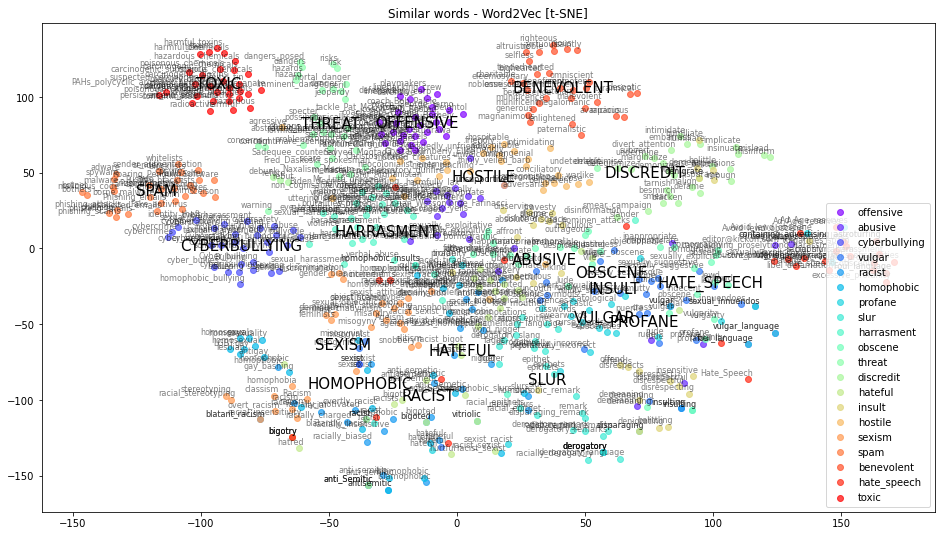

In [17]:
plotTSNE("Similar words - Word2Vec [t-SNE]", word_clusters_a, embedding_clusters, "SimilarWords - word2vec - t-SNE_1.png")

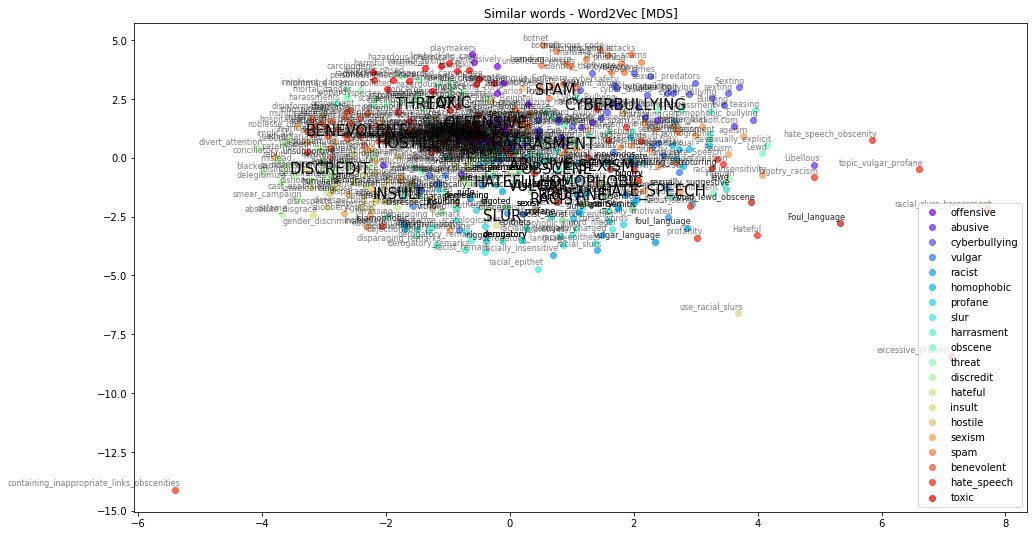

In [18]:
plotMDS("Similar words - Word2Vec [MDS]", word_clusters_a, embedding_clusters, "SimilarWords - word2vec - MDS_1.png")

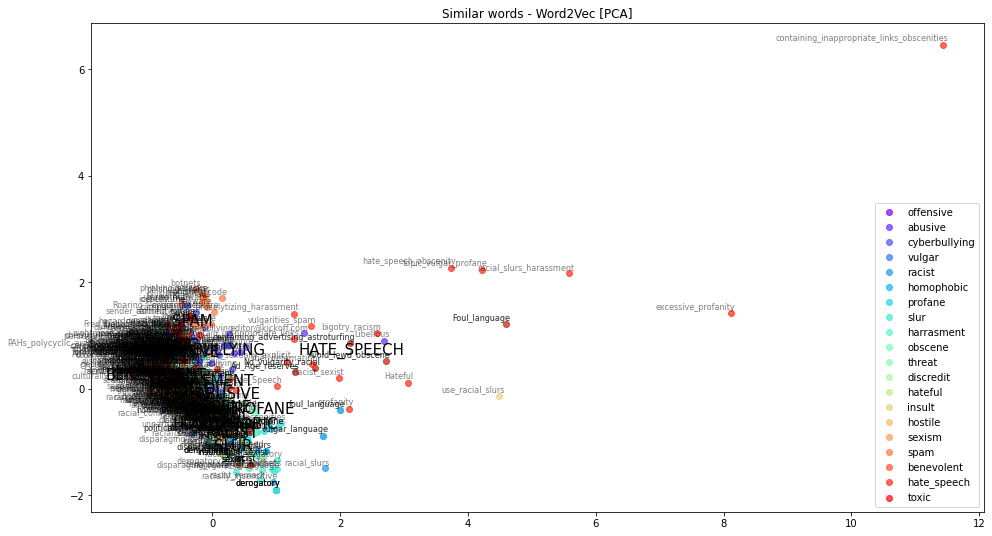

In [19]:
plotPCA("Similar words - Word2Vec [PCA]", word_clusters_a, embedding_clusters, "SimilarWords - word2vec - PCA_1.png")

## glove

In [18]:
# stran dala: douchebag, feminazi

In [20]:
TOP_N = 30
KEYS = { \
    "offensive": set(), 
    "abusive": set(), 
    "cyberbullying": set(), 
    "vulgar": set(), 
    "racist": set(), 
    "homophobic": set(), 
    "profane": set(), 
    "slur": set(), 
    "harrasment": set(), 
    "obscene": set(), 
    "threat": set(), 
    "discredit": set(), 
    "hateful": set(), 
    "insult": set(), 
    "hostile": set(),
    "sexism": set(),
    "spam": set(),
    "benevolent": set(),
    "toxic": set(),        
}
FIXED_KEYS = list(KEYS.keys())

lemmatizer = WordNetLemmatizer() 
ps = PorterStemmer() 


for key in KEYS.keys():
    lemma = lemmatizer.lemmatize(key)
    stem = ps.stem(key)
    KEYS[key].add(lemma)
    KEYS[key].add(stem)
    KEYS[key].add(key)
KEYS

{'offensive': {'offens', 'offensive'},
 'abusive': {'abus', 'abusive'},
 'cyberbullying': {'cyberbulli', 'cyberbullying'},
 'vulgar': {'vulgar'},
 'racist': {'racist'},
 'homophobic': {'homophob', 'homophobic'},
 'profane': {'profan', 'profane'},
 'slur': {'slur'},
 'harrasment': {'harras', 'harrasment'},
 'obscene': {'obscen', 'obscene'},
 'threat': {'threat'},
 'discredit': {'discredit'},
 'hateful': {'hate', 'hateful'},
 'insult': {'insult'},
 'hostile': {'hostil', 'hostile'},
 'sexism': {'sexism'},
 'spam': {'spam'},
 'benevolent': {'benevol', 'benevolent'},
 'toxic': {'toxic'}}

In [21]:
model_gn = gensim.downloader.load('glove-wiki-gigaword-300')

In [22]:
word_clusters, embedding_clusters = getSimilarWords(model_gn)

{'offensive', 'offens'} -- offense
{'offensive', 'offens'} -- offensives
{'offensive', 'offens'} -- offensively
{'abus', 'abusive'} -- abuse
{'abus', 'abusive'} -- abused
{'abus', 'abusive'} -- abusing
{'vulgar'} -- vulgarity
{'racist'} -- racists
{'homophob', 'homophobic'} -- homophobia
{'profane', 'profan'} -- profanity
{'slur'} -- slurs
{'harrasment', 'harras'} -- harrassment
{'obscen', 'obscene'} -- obscenity
{'obscen', 'obscene'} -- obscenities
{'threat'} -- threats
{'threat'} -- threatening
{'threat'} -- threatened
{'threat'} -- threaten
{'threat'} -- threatens
{'discredit'} -- discrediting
{'discredit'} -- discredited
{'hate', 'hateful'} -- hate
{'insult'} -- insulting
{'insult'} -- insults
{'insult'} -- insulted
{'hostil', 'hostile'} -- hostility
{'sexism'} -- heterosexism
{'spam'} -- spammers
{'spam'} -- spamming
{'spam'} -- spammer
{'spam'} -- anti spam
{'benevolent', 'benevol'} -- benevolence
{'toxic'} -- toxicity


In [23]:
displayDF(word_clusters)

,offensive,abusive,cyberbullying,vulgar,racist,homophobic,profane,slur,harrasment,obscene,threat,discredit,hateful,insult,hostile,sexism,spam,benevolent,toxic
0,defensive,neglectful,bullying,profane,homophobic,sexist,vulgar,derogatory,romish,indecent,danger,undermine,bigoted,affront,unfriendly,homophobia,e-mail,patrolmen,poisonous
1,lineman,inappropriate,cyberstalking,obscene,sexist,racist,raunchy,homophobic,pi96,lewd,posed,embarrass,hurtful,disrespect,takeover,racism,filtering,malevolent,chemicals
2,linemen,sexually,cyber-bullying,raunchy,semitic,misogynistic,obscene,epithets,nonfeasance,vulgar,pose,intimidate,racist,offend,belligerent,misogyny,phishing,omnipotent,toxins
3,coordinator,stepfather,sexting,risque,xenophobic,slurs,vulgarity,disparaging,zety,profane,possibility,defame,vile,humiliation,antagonistic,ageism,email,fraternal,radioactive
4,attack,behavior,anti-gay,crass,anti-semitic,misogynist,misogynistic,uttered,depressurisation,pornographic,warned,rebut,homophobic,shame,enemy,bigotry,spyware,beneficent,hazardous
5,quarterback,verbally,vigilantism,sexist,antisemitic,bigoted,ribald,racist,keyrates,inappropriate,warning,humiliate,sexist,provocation,takeovers,anti-semitism,senders,domineering,contaminants
6,blitz,overbearing,victimisation,tasteless,slurs,antisemitic,irreverent,nigger,jiwamol,insulting,poses,tarnish,despicable,ridicule,threats,elitism,emails,paternalistic,pesticides
7,forces,bullying,victimization,suggestive,racism,anti-semitic,scatological,epithet,demoralisation,defamatory,imminent,smear,intolerant,embarrassment,aggressive,classism,mails,villainous,waste
8,fighting,disrespectful,self-harm,derogatory,hateful,xenophobic,rude,sexist,supunnabul,gestures,dangers,destabilize,idiotic,disrespectful,fend,stereotyping,junk,saintly,contaminated
9,tackle,domineering,harrassment,disrespectful,bigoted,semitic,bawdy,semitic,ryryryryryry,immoral,possible,portray,disgusting,injustice,enemies,antisemitism,faxes,tyrannical,wastes


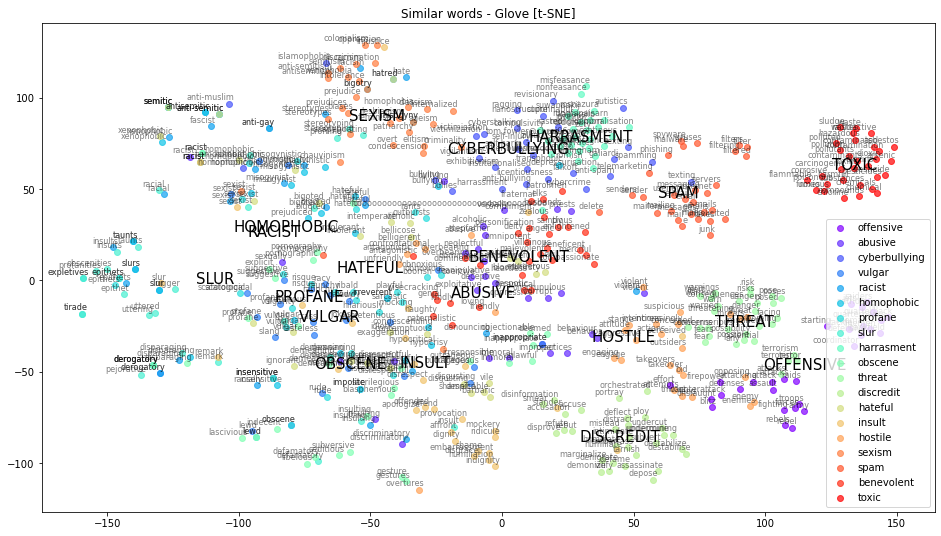

In [24]:
plotTSNE("Similar words - Glove [t-SNE]", word_clusters, embedding_clusters, "SimilarWords - Glove - t-SNE_1.png")

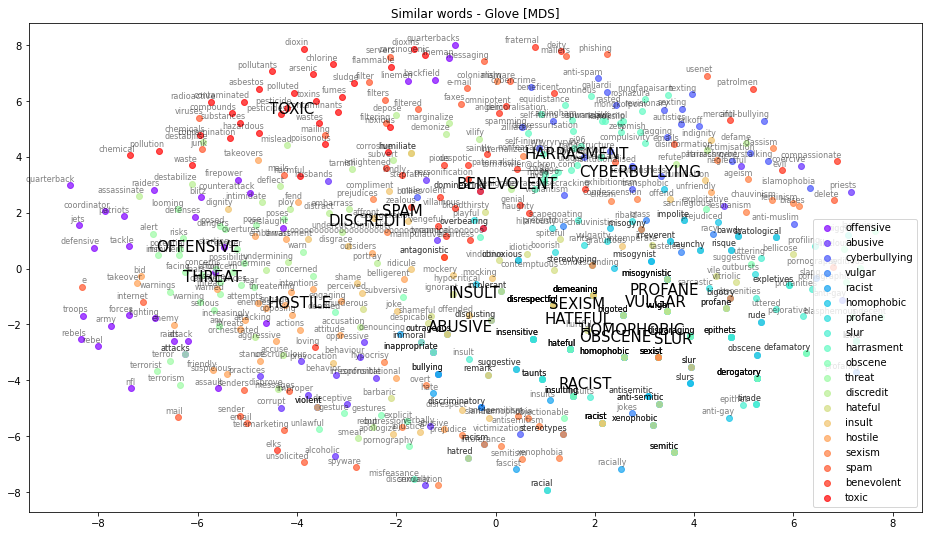

In [25]:
plotMDS("Similar words - Glove [MDS]", word_clusters, embedding_clusters, "SimilarWords - Glove - MDS_1.png")

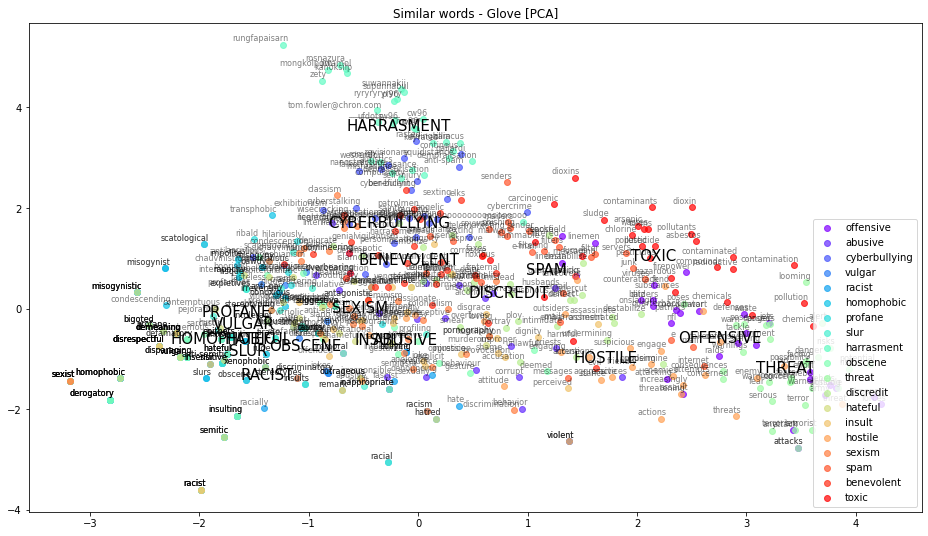

In [26]:
plotPCA("Similar words - Glove [PCA]", word_clusters, embedding_clusters, "SimilarWords - Glove - PCA_1.png")

## fasttext

In [18]:
# Run first time only to download model
import fasttext.util
#fasttext.util.download_model('en', if_exists='ignore')  # English
ft = fasttext.load_model('cc.en.300.bin')


In [ ]:
model_gn = load_facebook_vectors("cc.en.300.bin")

In [ ]:
TOP_N = 20
KEYS = { \
   "people": set(),
    "white": set(),
    "terror": set(),
    "women": set(),
    "sexist": set(),
    "classy": set(),
    "sassy": set(),
    "nasty":set(),
    "stupid": set(),
    "shit": set(),
    "idiot": set(),
    "trump": set(),
    "nigga": set(),
    "giveaway": set(),
    "game": set(),
    "enter": set(),
    "guy": set(),
    "good": set(),
    "gone": set(),
    "world": set(),
    "fuck": set(),
    "little": set(),
    "ass": set(),
    "stupid": set(),
    "bitch": set(),
    "die": set(),
    "block":set()
    
}
FIXED_KEYS = list(KEYS.keys())

lemmatizer = WordNetLemmatizer() 
ps = PorterStemmer() 


for key in KEYS.keys():
    lemma = lemmatizer.lemmatize(key)
    stem = ps.stem(key)
    KEYS[key].add(lemma)
    KEYS[key].add(stem)
    KEYS[key].add(key)
KEYS